# Optimize clustering into playlists with 5000 songs

# Import libraries

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# This will ensure the outputs of the .transform() method are pandas data frames
from sklearn import set_config
set_config(transform_output='pandas')

---
# Import Data and Select Features

In [2]:
songs = pd.read_csv("../data/3_spotify_5000_songs.csv")
songs.columns = songs.columns.str.strip()
songs = songs.set_index(["name", "artist"])
songs_df = songs.drop(columns=["id", "html",  "type", "Unnamed: 0", 
                               "time_signature", "duration_ms", "mode", "key", 
                               "loudness", "speechiness"])
songs_df.head()

,,danceability,energy,acousticness,instrumentalness,liveness,valence,tempo
name,artist,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.658,0.2590,0.694,0.000059,0.975,0.306,110.376
Saudade De Bahia,Antônio Carlos Jobim,0.742,0.3990,0.217,0.000002,0.107,0.693,125.039
"Canta Canta, Minha Gente",Martinho Da Vila,0.851,0.7300,0.453,0.000063,0.124,0.905,93.698
Mulher Eu Sei,Chico César,0.705,0.0502,0.879,0.000041,0.386,0.524,106.802
Rosa Morena,Kurt Elling,0.651,0.1190,0.916,0.000343,0.104,0.402,120.941


---
# Scale: standard scaler

In [3]:
scaler = StandardScaler()
songs_standard = scaler.fit_transform(songs_df)

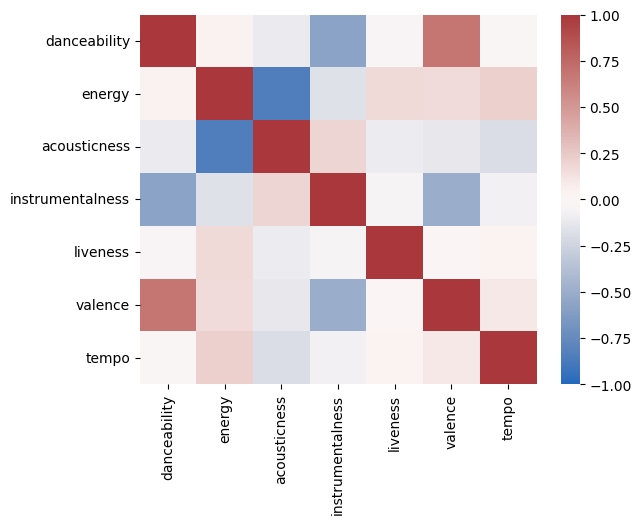

In [10]:
# calculate the correlation matrix on the numeric columns
corr = songs_standard.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr,cmap="vlag", annot=False, vmin=-1, vmax=1);

---
# Cluster
Each playlist should have between 50 and 250 songs. For a dataset with roughly 5000 songs, that means between 20 and 100 clusters. We chose 52

In [4]:
# your data here
scaled_audio_features = songs_standard.copy()
n_clusters = 52
random_state = 42

#----
myKMeans = KMeans(n_clusters=n_clusters, random_state=random_state) 
myKMeans.fit(scaled_audio_features)

songs['cluster'] = myKMeans.labels_
scaled_audio_features['cluster'] = myKMeans.labels_

---
# Evaluate Clusters

In [12]:
scaled_audio_features.value_counts('cluster').describe()

count     52.000000
mean     100.673077
std       47.733213
min       21.000000
25%       63.000000
50%       92.500000
75%      123.000000
max      258.000000
Name: count, dtype: float64

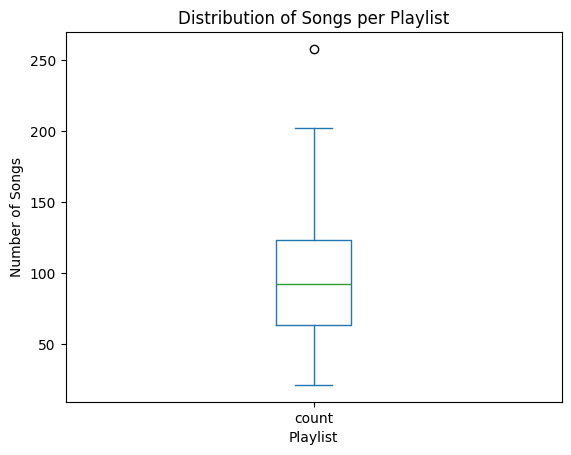

In [24]:
scaled_audio_features.value_counts('cluster').plot(
    kind='box', 
    xlabel='Playlist', 
    ylabel='Number of Songs', 
    title='Distribution of Songs per Playlist');


## Average feature values

### Exemplary clusters

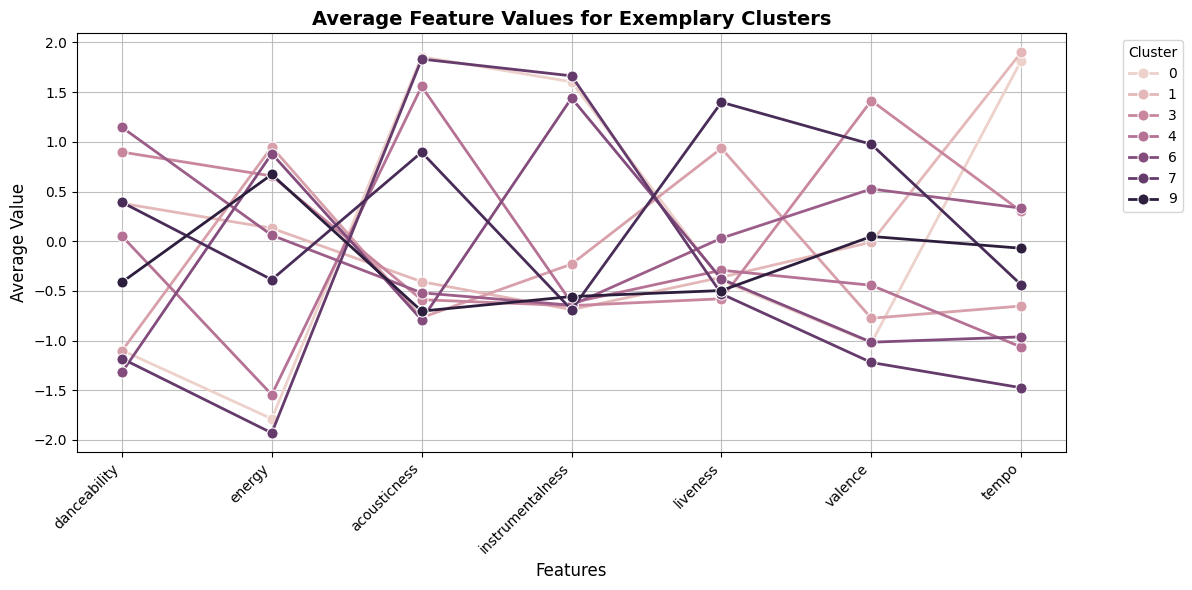

In [5]:
plt.figure(figsize=(12, 6))
cluster_means = scaled_audio_features.groupby('cluster').mean().iloc[:10,:]
cluster_means_reset = cluster_means.reset_index()

# Melt the dataframe for seaborn lineplot
cluster_melted = cluster_means_reset.melt(id_vars='cluster', 
                                           var_name='feature',
                                           value_name='average_value')

# Create seaborn lineplot
sns.lineplot(data=cluster_melted, x='feature', y='average_value', 
             hue='cluster', marker='o', linewidth=2, markersize=8)

plt.xlabel('Features', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.title('Average Feature Values for Exemplary Clusters', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.8)
plt.tight_layout()
plt.show()

### Mean of all clusters with confidence interval

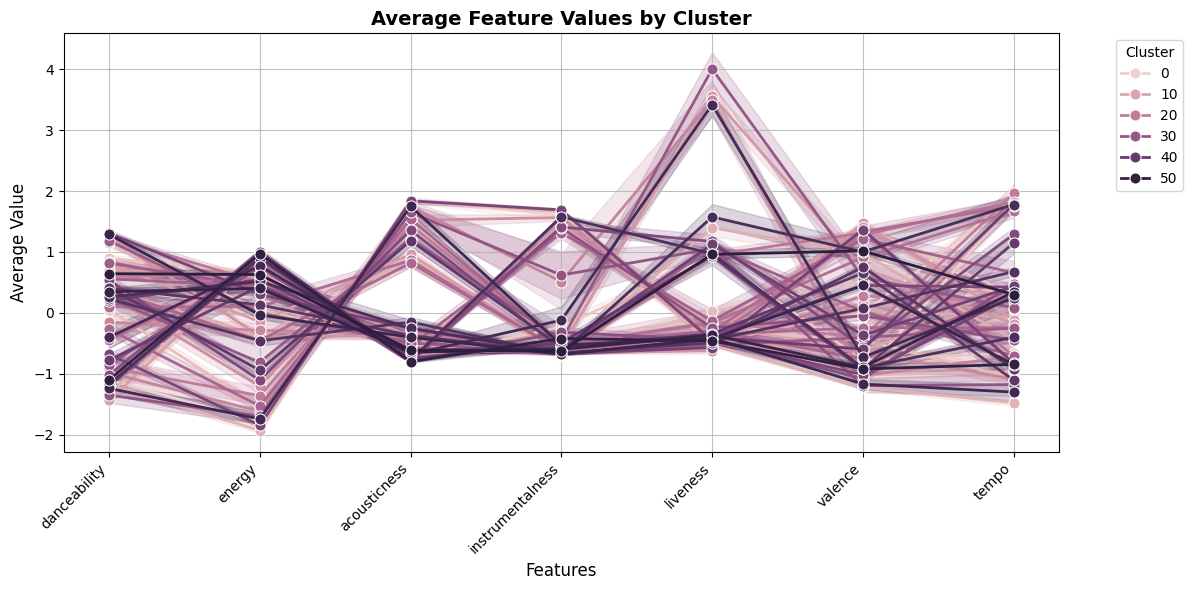

In [6]:
plt.figure(figsize=(12, 6))
cluster_means = scaled_audio_features

# Melt the dataframe for seaborn lineplot
cluster_melted = cluster_means.melt(id_vars='cluster', 
                                           var_name='feature', 
                                           value_name='value')

# Create seaborn lineplot
sns.lineplot(data=cluster_melted, x='feature', y='value', 
             hue='cluster', marker='o', linewidth=2, markersize=8)

plt.xlabel('Features', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.title('Average Feature Values by Cluster', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.8)
plt.tight_layout()
plt.show()

---
## Send playlists to spotify

In [57]:
import spotipy
import pickle
from spotipy.oauth2 import SpotifyOAuth

In [58]:
import keys
scope = 'playlist-modify-public'
username = keys.USERNAME
redirectUri = keys.REDIRECTURI
client_id = keys.CLIENT_ID 
client_secret = keys.CLIENT_SECRET

token = SpotifyOAuth(scope=scope,
                     username=username,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=redirectUri,
                     )
spotifyObject = spotipy.Spotify(auth_manager = token)

In [59]:
playlist_collection = {}
for i in range(10): #n_clusters # This range must match the number of clusters
    playlist_name = f'cluster_{i}'  # Here, we will create simple playlist names indicating which cluster created the playlist
    playlist_description= 'this is a test list'
    playlist_id = spotifyObject.user_playlist_create(user=username,
                                                     name=playlist_name,
                                                     public=True,
                                                     description=playlist_description)['id']
    id_list = list(songs.loc[songs_df["cluster"] == i]
                            .sample(5)  # Here, we simply take 5 songs randomly from each cluster
                            .id
                   )
     # Spotify needs cetain text wrappers around ID numbers to identify the target as a track, a playlist, etc.
    uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
    spotifyObject.user_playlist_add_tracks(user=username,playlist_id=playlist_id,tracks=uris)
    playlist_collection[playlist_name] = playlist_id

# When this code is run, either a browser window will open, or in Google Colab a URL will appear
# This URL will ask you to sign in to Spotify
# After signing in, copy the URL you are redirected to and paste it in the box that pops up

### Overwriting an existing playlist
As you refine your model, you may want to repopulate your existing playlists instead of creating new ones. To do this, you'll need to save the playlist_ids you created above, either as a pickled object or by writing them to a text file.

In [ ]:
# Playlist IDs can be saved for later
with open("./playlists.pkl", "wb") as f:
    pickle.dump(playlist_collection, f)

In [63]:
with open("./playlists.pkl", "rb") as f:
    playlist_collection = pickle.load(f)
uris = [f'spotify:track:{str(id).strip()}' for id in songs.sample(10).id]
playlist_id = playlist_collection["cluster_0"] # We now replace the 5 songs in playlist 0 with 10 different songs
spotifyObject.user_playlist_replace_tracks(user=username, playlist_id=playlist_id, tracks=uris)

{'snapshot_id': 'AAAAA8h717wEMPXT2GhbpYGVd4AVVepF'}

---
# Suggestions beyond the algorithm
* include songs liked by user
* include popular songs
* -> songs could be in more than one playlist
* include curated lists!!!
Either spotify API or kaggle dataset